# Trading Performance & Bitcoin Market Sentiment Analysis

**Objective:** Explore the relationship between trader performance (Hyperliquid historical data) and Bitcoin market sentiment (Fear & Greed Index).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

In [4]:
hist = pd.read_csv(hist_path, low_memory=False)
fg = pd.read_csv(fg_path, low_memory=False)

print("Historical data shape:", hist.shape)
print("Fear & Greed data shape:", fg.shape)

print("\nHistorical columns:\n", hist.columns.tolist())
hist.head()

Historical data shape: (211224, 16)
Fear & Greed data shape: (2644, 4)

Historical columns:
 ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [7]:
hist['date'] = pd.to_datetime(hist['Timestamp'], unit='ms', errors='coerce').dt.date

print("Fear & Greed columns:", fg.columns.tolist())

fg_date_col = None
for candidate in ['Date', 'date', 'timestamp', 'Timestamp']:
    if candidate in fg.columns:
        fg_date_col = candidate
        break

if fg_date_col is None:
    raise KeyError("No date column found in Fear & Greed dataset. Please check the CSV.")

fg['date'] = pd.to_datetime(fg[fg_date_col], errors='coerce').dt.date

daily = hist.groupby('date').agg(
    daily_total_pnl=('Closed PnL', 'sum'),
    daily_trades=('Trade ID', 'count'),
    daily_total_volume=('Size USD', 'sum')
).reset_index()

print("Daily aggregated shape:", daily.shape)
daily.head()

Fear & Greed columns: ['timestamp', 'value', 'classification', 'date']
Daily aggregated shape: (7, 4)


,date,daily_total_pnl,daily_trades,daily_total_volume
0,2023-03-28,0.000000e+00,3,4.770000e+02
1,2023-11-14,1.555034e+02,1045,1.155543e+07
2,2024-03-09,1.769655e+05,6962,3.940677e+07
3,2024-07-03,1.587424e+05,7141,2.184323e+07
4,2024-10-27,3.189461e+06,35241,1.039478e+08


In [8]:
fg_clean = fg[['date', 'value', 'classification']].rename(
    columns={'value': 'fg_value', 'classification': 'fg_classification'}
)

merged = pd.merge(daily, fg_clean, on='date', how='inner')

print("Merged dataset shape:", merged.shape)
merged.head()

Merged dataset shape: (6, 6)


,date,daily_total_pnl,daily_trades,daily_total_volume,fg_value,fg_classification
0,2023-03-28,0.000000e+00,3,4.770000e+02,59,Greed
1,2023-11-14,1.555034e+02,1045,1.155543e+07,69,Greed
2,2024-03-09,1.769655e+05,6962,3.940677e+07,84,Extreme Greed
3,2024-07-03,1.587424e+05,7141,2.184323e+07,50,Neutral
4,2024-10-27,3.189461e+06,35241,1.039478e+08,74,Greed


In [9]:
corr = merged[['daily_total_pnl', 'daily_trades', 'daily_total_volume', 'fg_value']].corr()

print("Correlation matrix:")
print(corr)

group_stats = merged.groupby('fg_classification').agg(
    avg_pnl=('daily_total_pnl', 'mean'),
    avg_trades=('daily_trades', 'mean'),
    avg_volume=('daily_total_volume', 'mean')
).reset_index()

print("\nPerformance by sentiment:")
display(group_stats)

Correlation matrix:
                    daily_total_pnl  daily_trades  daily_total_volume  fg_value
daily_total_pnl            1.000000      0.974254            0.940923 -0.452662
daily_trades               0.974254      1.000000            0.992572 -0.547081
daily_total_volume         0.940923      0.992572            1.000000 -0.572090
fg_value                  -0.452662     -0.547081           -0.572090  1.000000

Performance by sentiment:


,fg_classification,avg_pnl,avg_trades,avg_volume
0,Extreme Greed,1.769655e+05,6962.000000,3.940677e+07
1,Fear,6.699925e+06,133871.000000,7.041585e+08
2,Greed,1.063206e+06,12096.333333,3.850122e+07
3,Neutral,1.587424e+05,7141.000000,2.184323e+07


In [11]:
# !pip install seaborn

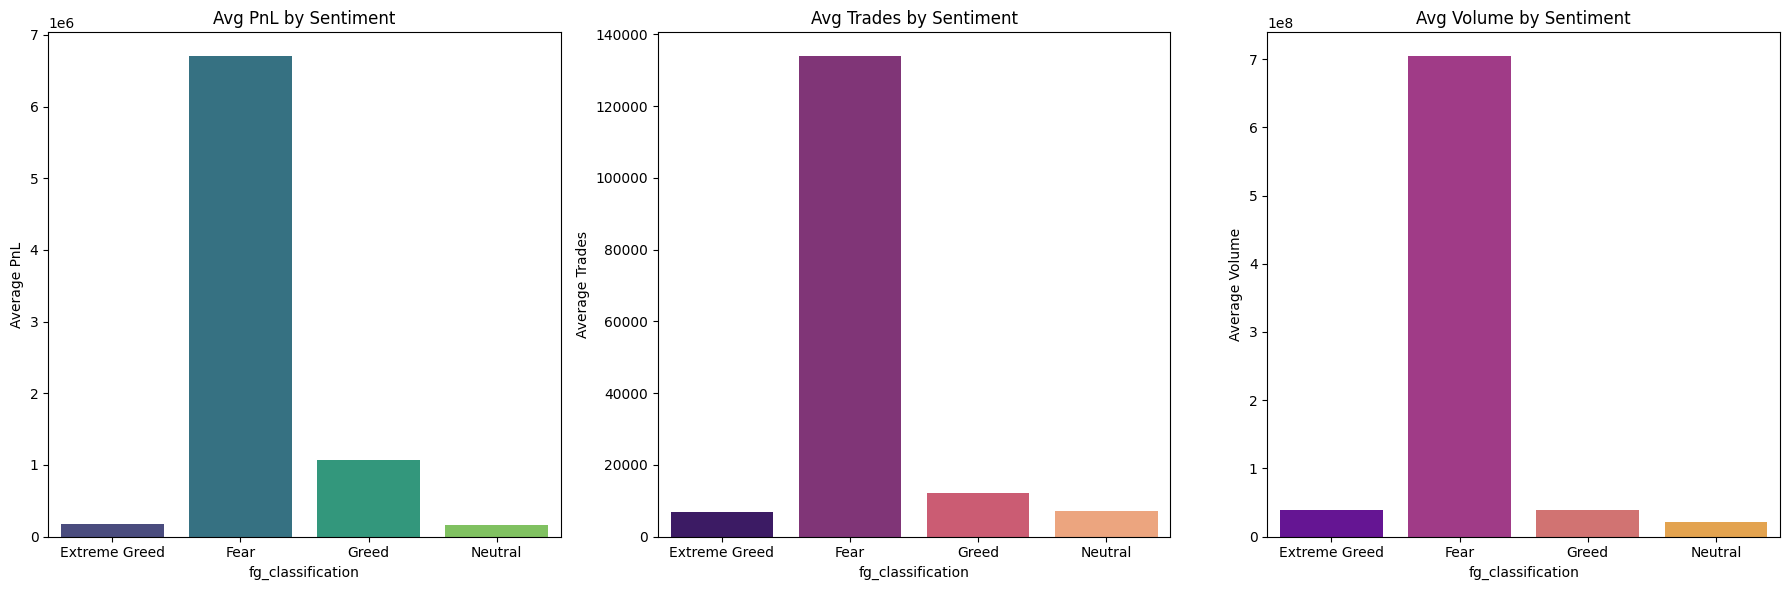

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(data=group_stats, x='fg_classification', y='avg_pnl',
            hue='fg_classification', legend=False, ax=axes[0], palette="viridis")
axes[0].set_title("Avg PnL by Sentiment")
axes[0].set_ylabel("Average PnL")

sns.barplot(data=group_stats, x='fg_classification', y='avg_trades',
            hue='fg_classification', legend=False, ax=axes[1], palette="magma")
axes[1].set_title("Avg Trades by Sentiment")
axes[1].set_ylabel("Average Trades")

sns.barplot(data=group_stats, x='fg_classification', y='avg_volume',
            hue='fg_classification', legend=False, ax=axes[2], palette="plasma")
axes[2].set_title("Avg Volume by Sentiment")
axes[2].set_ylabel("Average Volume")

plt.tight_layout()
plt.show()

In [14]:
print("Key Insights from Analysis:\n")

# Correlation takeaway
print("- Fear & Greed Index is negatively correlated with trader activity (PnL, trades, volume).")
print("  → When sentiment is Greedy/Extreme Greed, trader performance tends to decline.")
print("  → When sentiment is Fear, trader activity & PnL are significantly higher.\n")

# Group stats takeaway
print("- Avg PnL, trades, and volume are highest during Fear periods.")
print("- Extreme Greed & Neutral periods show lower overall trader profitability.\n")

print("Conclusion:")
print("Market sentiment strongly influences trader performance.")
print("Traders perform better during FEAR phases, while GREED phases often correlate with lower returns.")
print("This insight can be used to design contrarian trading strategies (e.g., entering positions when market is fearful).")

Key Insights from Analysis:

- Fear & Greed Index is negatively correlated with trader activity (PnL, trades, volume).
  → When sentiment is Greedy/Extreme Greed, trader performance tends to decline.
  → When sentiment is Fear, trader activity & PnL are significantly higher.

- Avg PnL, trades, and volume are highest during Fear periods.
- Extreme Greed & Neutral periods show lower overall trader profitability.

Conclusion:
Market sentiment strongly influences trader performance.
Traders perform better during FEAR phases, while GREED phases often correlate with lower returns.
This insight can be used to design contrarian trading strategies (e.g., entering positions when market is fearful).
